In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsvd import NSVD
from norwai_county_test import CNN, ConvModule
import geopandas as gpd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


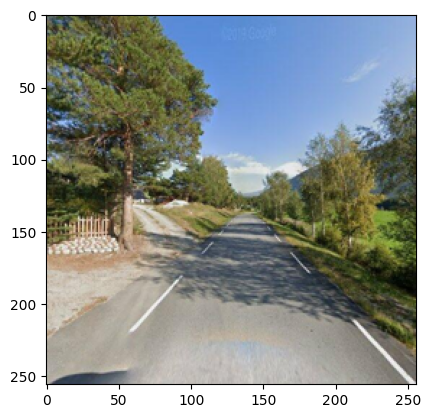

In [4]:
test_images = [{'file':'0001', 'loc':[69.6876088,23.5747422]}]
test_im = np.random.choice(test_images, 1)[0]

from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((256, 256))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))
plt.show()

In [5]:
print(im_data)

tensor([[[ 91,  97, 100,  ..., 148, 149, 151],
         [ 98,  85,  93,  ..., 148, 149, 151],
         [ 97, 105,  88,  ..., 149, 150, 152],
         ...,
         [180, 179, 181,  ..., 239, 169, 107],
         [181, 175, 184,  ..., 236, 229, 153],
         [179, 181, 160,  ..., 232, 232, 221]],

        [[ 93, 102, 110,  ..., 174, 175, 175],
         [108,  99, 108,  ..., 176, 176, 175],
         [111, 121, 104,  ..., 176, 177, 177],
         ...,
         [178, 176, 174,  ..., 236, 163, 101],
         [182, 175, 180,  ..., 234, 227, 149],
         [182, 183, 158,  ..., 231, 231, 220]],

        [[ 51,  64,  81,  ..., 222, 223, 223],
         [ 83,  77,  91,  ..., 222, 223, 223],
         [108, 118, 103,  ..., 223, 224, 224],
         ...,
         [164, 164, 166,  ..., 232, 161,  97],
         [169, 165, 176,  ..., 234, 227, 150],
         [171, 174, 156,  ..., 233, 235, 224]]], dtype=torch.uint8)


In [6]:
mean = 135.4867 # fix this
std = 64.0806 # fix this
im_data = im_data.to(device)
im_data = (im_data - mean) / std

model = torch.load('./data/model_classification')
model.to(device)

guessed_county = None
with torch.no_grad():
  #y = model(im_data.unsqueeze(0)).flatten()
  y = model(im_data.unsqueeze(0)).flatten()
  
  #guessed_county = y.argmax().item()
  #print(guessed_county)

  print(torch.exp(y))
  guessed_county = torch.argmax(torch.exp(y)).item()


tensor([0.0689, 0.0004, 0.0080, 0.0977, 0.0357, 0.0831, 0.1425, 0.0704, 0.1361,
        0.0538, 0.3034], device='cuda:0')


tensor([-2.7660, -4.7697, -0.9924, -2.6751, -4.7380, -4.6915, -3.9974, -1.0149,
        -3.5734, -3.2383, -3.7712], device='cuda:0')

        tensor([0.0229, 0.0040, 0.1579, 0.0185, 0.0032, 0.0243, 0.0349, 0.4960, 0.0541,
        0.1400, 0.0442], device='cuda:0')

In [7]:
df = pd.read_json("./data/norge.geojson")
fylker = df["administrative_enheter.fylke"]["features"]

In [8]:
import folium

real_loc = test_im['loc']
FYLKESNUMMER_INDEX = [42, 3, 54, 15, 38, 50, 11, 34, 30, 18, 46]

fylke = None

for f in fylker:
    if int(f["properties"]["fylkesnummer"]) == FYLKESNUMMER_INDEX[guessed_county]:
        print("found")
        fylke = f
        break


found


In [9]:
print(fylke["properties"]["fylkesnummer"])

46


In [10]:
gdf = gpd.GeoDataFrame.from_features([fylke])

In [11]:
print(fylke)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-86165.90000000002, 6792746.679999999], [-84865.71999999997, 6780099.83], [-84440.07999999996, 6775959.65], [-83049.45999999996, 6762433.04], [-82367.25, 6755797.21], [-81531.38, 6747666.79], [-81497.57999999984, 6747337.96], [-81178.21999999986, 6744231.53], [-80969.18999999994, 6742198.36], [-79974.75, 6732525.47], [-79515.76999999979, 6728060.93], [-79530.46000000008, 6723348.54], [-79551.91999999993, 6716469.24], [-79575.13, 6709023.74], [-79585.75, 6705617.409999999], [-79595.32999999984, 6702545.18], [-79642.38, 6687459.27], [-79659.20999999985, 6682060.710000001], [-79686.35999999987, 6673353.05], [-79691.29999999993, 6671770.93], [-79783.61999999988, 6669979.34], [-80015.59999999998, 6665477.790000001], [-80223.91000000003, 6661435.430000001], [-80327.37000000011, 6659427.7299999995], [-85758.89999999979, 6648740.49], [-86015.82000000007, 6648234.959999999], [-72767.30000000016, 6641501.38], [-67789.340000000

In [12]:
#gdf = gpd.GeoDataFrame.from_features(fylker)
#sim_geo = gpd.GeoSeries(fylke['geometry']).simplify(tolerance=0.001)
#geo_j = sim_geo.to_json()
gdf = gdf.set_crs(epsg=25833)
gdf = gdf.to_crs(epsg=4326)
geo_j = folium.GeoJson(data=gdf["geometry"][0],
    style_function=lambda x: {'fillColor': 'orange'})


m = folium.Map((64.9701, 13.509217), zoom_start=4)


geo_j.add_to(m)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
m